# STW7082CEM:  

Big Data Management and Data Visualization





# Installation of Pyspark

In [ ]:
!pip install pyspark

# Importing of important packages

In [ ]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import functions as F

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor

# Creating SparkSession

In [ ]:
spark = SparkSession.builder.appName('Bipluck Shrestha Coventry').getOrCreate()

#Importing csv file

In [ ]:
file_path = '/content/drive/MyDrive/big/vehicles.csv'
df_cars = spark.read.options(header=True, inferSchema=True, delimiter=',', multiLine=True).csv(file_path)

In [ ]:
df_cars.printSchema()

root
 |-- id: long (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (null

#  Data Cleaning

If we want to simplify our data, we can get rid of the columns that are not relevant for our analysis. The columns "url", "region_url", "image_url" and "description" do not provide any useful information for our purpose, so we can drop them from our dataframe. This will make our data more manageable and easier to work with.

One possible issue with the data is that the columns "lat" and "long" are not numeric, but string. This could affect the analysis and visualization of the spatial information. To fix this, we need to remove any non-numeric characters from these columns, such as letters or symbols. We also need to validate the range of the values in these columns, to make sure they are within the valid latitude and longitude ranges. Another possible issue is that some categorical columns use a special value like "other" to indicate missing data. This could skew the distribution and frequency of these columns. To fix this, we need to replace these values with nulls, so that they are not counted as a category.

In [ ]:
# these columns are useless to us, drop them

drop_cols = ['url', 'region_url', 'image_url', 'description']

df_cars = df_cars.drop(*drop_cols)

In [ ]:
# both null values and null indicators(other) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('other', None, subset=['cylinders'])

In [ ]:
# both null values and null indicators(missing) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('missing', None, subset=['title_status'])

In [ ]:
# Latitude should be between (-90, 90), otherwise set null

df_cars = df_cars.withColumn('lat', F.when(F.col('lat').rlike('^-?\d+\.?\d+$'), F.col('lat')))
df_cars = df_cars.withColumn('lat', F.col('lat').cast(types.FloatType()))
df_cars = df_cars.withColumn('lat', F.when((-90 <= F.col('lat')) & (F.col('lat') <= 90), F.col('lat')))

In [ ]:
# Longitude should be between (-180, 180), otherwise set null

df_cars = df_cars.withColumn('long', F.when(F.col('long').rlike('^-?\d+\.?\d+$'), F.col('long')))
df_cars = df_cars.withColumn('long', F.col('long').cast(types.FloatType()))
df_cars = df_cars.withColumn('long', F.when((-180 <= F.col('long')) & (F.col('long') <= 180), F.col('long')))

In [ ]:
# Posting date should be in format yyyy-MM-dd HH:mm:ss.SSSS

df_cars = df_cars.withColumn('posting_date', F.when(F.col('posting_date').rlike('^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}$'), F.col('posting_date')))
df_cars = df_cars.withColumn('posting_date', F.col('posting_date').cast(types.TimestampType()))

# Descriptive Statistics
Hint: If data is too big you can sample it before the descriptive stat calculations

In [ ]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+-------------------+------------------+------------------+-----------------+------------------+
|summary|              price|              year|          odometer|              lat|              long|
+-------+-------------------+------------------+------------------+-----------------+------------------+
|  count|             426582|            425377|            422182|           365481|            367830|
|   mean|  75240.00097753773|2011.2356544900172|  98019.2444514451|38.27485954294108|-92.92308876290198|
| stddev|1.218653645968038E7|   9.4529441236719|213407.41232087038|5.757416442913367| 20.91019012781645|
|    min|                  0|              1900|                 0|       -84.122246|        -159.82773|
|    25%|               5900|              2008|             37675|          34.4329|           -106.62|
|    50%|              13950|              2013|             85519|          39.0278|        -87.322266|
|    75%|              26455|              2017|       

# Data Wrangling¶

The "price" and "odometer" columns in the dataset show a right skewed distribution, meaning that the mean is larger than the median. This indicates that there are some outliers with very high values that affect the average. To reduce the impact of these outliers and normalize the distribution, we can apply a log transformation to these columns. This will also help to scale down the numbers and reduce the standard deviation. Another preprocessing step we can do is to split the "posting_date" column into three new columns: "posting_year", "posting_month", and "posting_day". This will allow us to analyze the data by different time periods and see if there are any seasonal or temporal patterns."

In [ ]:
# both columns starts with 0, log(0) is undefined so we should put +1

df_cars = df_cars.withColumn('price', F.log10(F.col('price') + 1))
df_cars = df_cars.withColumn('odometer', F.log10(F.col('odometer') + 1))

In [ ]:
# date column to year and month columns

df_cars = df_cars.withColumn('posting_year', F.year(F.col('posting_date')))
df_cars = df_cars.withColumn('posting_month', F.month(F.col('posting_date')))

df_cars = df_cars.drop('posting_date')

In [ ]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|             price|              year|          odometer|              lat|              long|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|            426582|            425377|            422182|           365481|            367830|
|   mean|3.7736931253525903|2011.2356544900172| 4.745384684351896|38.27485954294108|-92.92308876290198|
| stddev|1.2051273580604176|   9.4529441236719|0.7163314827973487|5.757416442913367| 20.91019012781645|
|    min|               0.0|              1900|               0.0|       -84.122246|        -159.82773|
|    25%|3.7709256146389993|              2008| 4.576064788225377|          34.4329|           -106.62|
|    50%| 4.144605338714745|              2013| 4.932067692200722|          39.0278|        -87.322266|
|    75%| 4.422524181905646|              2017|5.125608119717532

# Creating clean data csv for tableau

In [ ]:
df_cars.coalesce(1).write.csv("vehicles_clean", header=True)

# Data Visualization on Python

In [ ]:
df_cars.createOrReplaceTempView('cardata')

#### Histogram

In [ ]:
df_result = spark.sql('SELECT manufacturer, price FROM cardata WHERE manufacturer IN ("chevrolet", "ford", "toyota")')
df_result = df_result.toPandas()

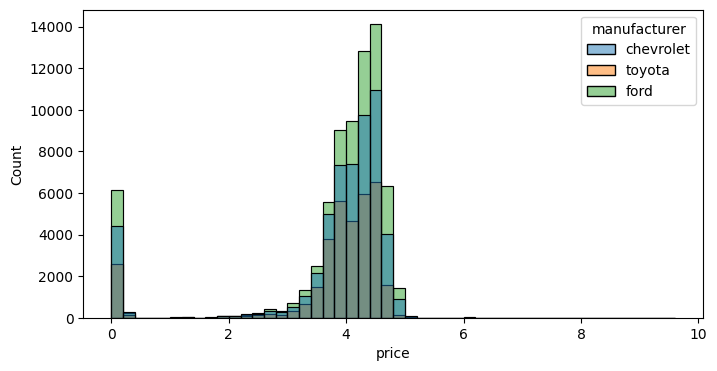

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = sns.histplot(data=df_result, x='price', hue='manufacturer', binwidth=0.2, ax=ax)

plt.show()

#### Scatter Plot

In [ ]:
df_result = spark.sql('SELECT condition, odometer, price FROM cardata')
df_result = df_result.toPandas()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


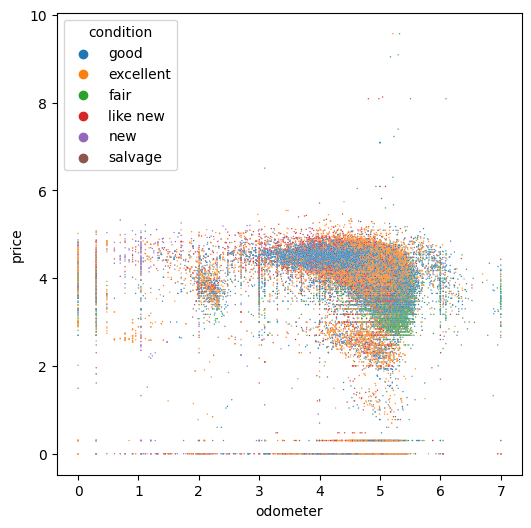

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

_ = sns.scatterplot(data=df_result, x='odometer', y='price', hue='condition', ax=ax, s=1)

plt.show()

#### Pie Chart

In [ ]:
df_result = spark.sql('SELECT condition FROM cardata')
df_result = df_result.toPandas()

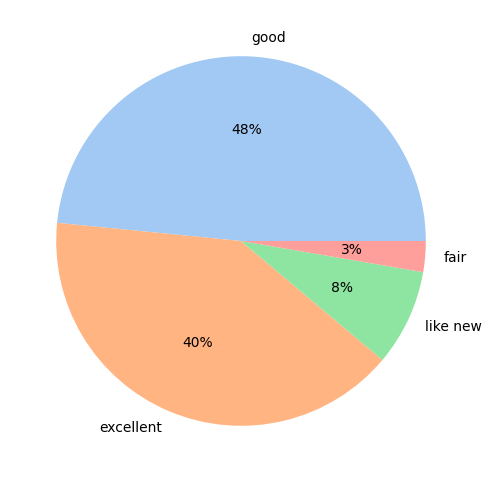

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

data = df_result['condition'].value_counts().nlargest(4)
colors = sns.color_palette('pastel')

plt.pie(data.values, labels=data.index, colors=colors, autopct='%.0f%%')
plt.show()

# Category Dropping
Some columns in our dataset have a large number of categories, which can make the analysis more complex and noisy. To simplify the data, we can drop the categories that have a low frequency of occurrence and keep only the most common ones. This way, we can reduce the dimensionality and improve the performance of our models.

In [ ]:
num_cols = ['year', 'odometer', 'lat', 'long', 'posting_year', 'posting_month']

cat_cols = ['region', 'manufacturer', 'model', 'condition', \
            'cylinders', 'fuel', 'title_status', 'transmission',\
           'VIN', 'drive', 'size', 'type', 'paint_color', 'county', 'state']

In [ ]:
n = 32

for col in cat_cols:
    most_freq = df_cars.groupBy(col).count().orderBy('count', ascending=False).take(n - 1)
    most_freq = spark.createDataFrame(most_freq).toPandas()
    most_freq = most_freq[col].tolist()

    df_cars = df_cars.withColumn(col, F.when(F.col(col).isin(most_freq), F.col(col)))

# Imputation

#### On Numeric Columns

In [ ]:
imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
model = imputer.fit(df_cars)
df_cars = model.transform(df_cars)

#### On Categorical Columns

In [ ]:
df_cars = df_cars.fillna('unknown', subset=cat_cols)

#### Categorical Column Encoding

In [ ]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    df_cars = indexer.fit(df_cars).transform(df_cars)

df_cars = df_cars.drop(*cat_cols)

# Creating Training DataSet

In [ ]:
cols = df_cars.columns
cols.remove('id')
cols.remove('price')

assembler = VectorAssembler(inputCols=cols, outputCol='features')

df_cars = assembler.transform(df_cars)

In [ ]:
df_data = df_cars.select(F.col('features'), F.col('price').alias('label'))
df_train, df_test = df_data.randomSplit([0.8, 0.2])

#### Performing Linear Regression

In [ ]:
classifier=LinearRegression(featuresCol='features',labelCol='label');
evaluator = RegressionEvaluator()
grid = ParamGridBuilder().build()

In [ ]:
cv = CrossValidator(estimator=classifier, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)

cv_model = cv.fit(df_train)

In [ ]:
cv_model.avgMetrics

[1.1815388340972839]

In [ ]:
df_test = cv_model.bestModel.transform(df_test.drop("prediction"))

In [ ]:
df_test.show(5)

+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|(21,[0,1,2,3,4,5]...|3.6986224297020978|3.5854464300616886|
|(21,[0,1,2,3,4,5]...| 3.777861624176242|3.5839870555911375|
|(21,[0,1,2,3,4,5]...| 4.204147125212848|3.6233858877265774|
|(21,[0,1,2,3,4,5]...| 4.204147125212848|3.6233858877265774|
|(21,[0,1,2,3,4,5]...| 4.301029995663981|3.5886148982473927|
+--------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
RegressionEvaluator(predictionCol='prediction', labelCol='label').evaluate(df_test)

1.1858331118974916

#### Dession Tree

In [ ]:
classifier=DecisionTreeRegressor(featuresCol="features", labelCol="label");
evaluator = RegressionEvaluator()
grid = ParamGridBuilder().build()

In [ ]:
cv = CrossValidator(estimator=classifier, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)

cv_model = cv.fit(df_train)

In [ ]:
df_test = cv_model.bestModel.transform(df_test)

In [ ]:
df_test.show(5)

+--------------------+------------------+-----------------+
|            features|             label|       prediction|
+--------------------+------------------+-----------------+
|(21,[0,1,2,3,4,5]...|3.6986224297020978|3.726601176605052|
|(21,[0,1,2,3,4,5]...| 3.777861624176242|3.726601176605052|
|(21,[0,1,2,3,4,5]...| 4.204147125212848|3.726601176605052|
|(21,[0,1,2,3,4,5]...| 4.204147125212848|3.726601176605052|
|(21,[0,1,2,3,4,5]...| 4.301029995663981|3.726601176605052|
+--------------------+------------------+-----------------+
only showing top 5 rows



In [ ]:
RegressionEvaluator(predictionCol='prediction', labelCol='label').evaluate(df_test)

1.114702839291372

#### Random Forest

In [ ]:
classifier = RandomForestRegressor(featuresCol='features', labelCol='label')
evaluator = RegressionEvaluator()
grid = ParamGridBuilder().build()

In [ ]:
cv = CrossValidator(estimator=classifier, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)

cv_model = cv.fit(df_train)

In [ ]:
cv_model.avgMetrics

[1.1056138039676053]

In [ ]:
df_test = cv_model.bestModel.transform(df_test)

In [ ]:
df_test.show(5)

+--------------------+------------------+-----------------+
|            features|             label|       prediction|
+--------------------+------------------+-----------------+
|(21,[0,1,2,3,4,5]...|3.6986224297020978|3.744584746601391|
|(21,[0,1,2,3,4,5]...| 3.777861624176242|3.744584746601391|
|(21,[0,1,2,3,4,5]...| 4.204147125212848|3.744584746601391|
|(21,[0,1,2,3,4,5]...| 4.204147125212848|3.744584746601391|
|(21,[0,1,2,3,4,5]...| 4.301029995663981|3.744584746601391|
+--------------------+------------------+-----------------+
only showing top 5 rows



In [ ]:
RegressionEvaluator(predictionCol='prediction', labelCol='label').evaluate(df_test)

1.1069182670301154